In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append('../')
import glob

import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ImageNormalize, stretch

from plot.plot_result import image_to_profile, sci_to_profile

band_labels = ['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']
psf_path = ['~/Desktop/GALFIT/GalfitModified/io/psf/' + band.lower() + '_psf.fits' for band in band_labels]
psf_imglist = [fits.getdata(path) for path in psf_path]
pix_scale = 0.03 # arcsec/pixel

In [3]:
# Plot Setting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

# First show one single component fit demo

In [3]:
img_name = 'nircam4'
sample_base = '../io/sample/' + img_name + '/'
sample_id = '20408'

sample_dir = sample_base + sample_id + '/'
output_name = 'output_linear'

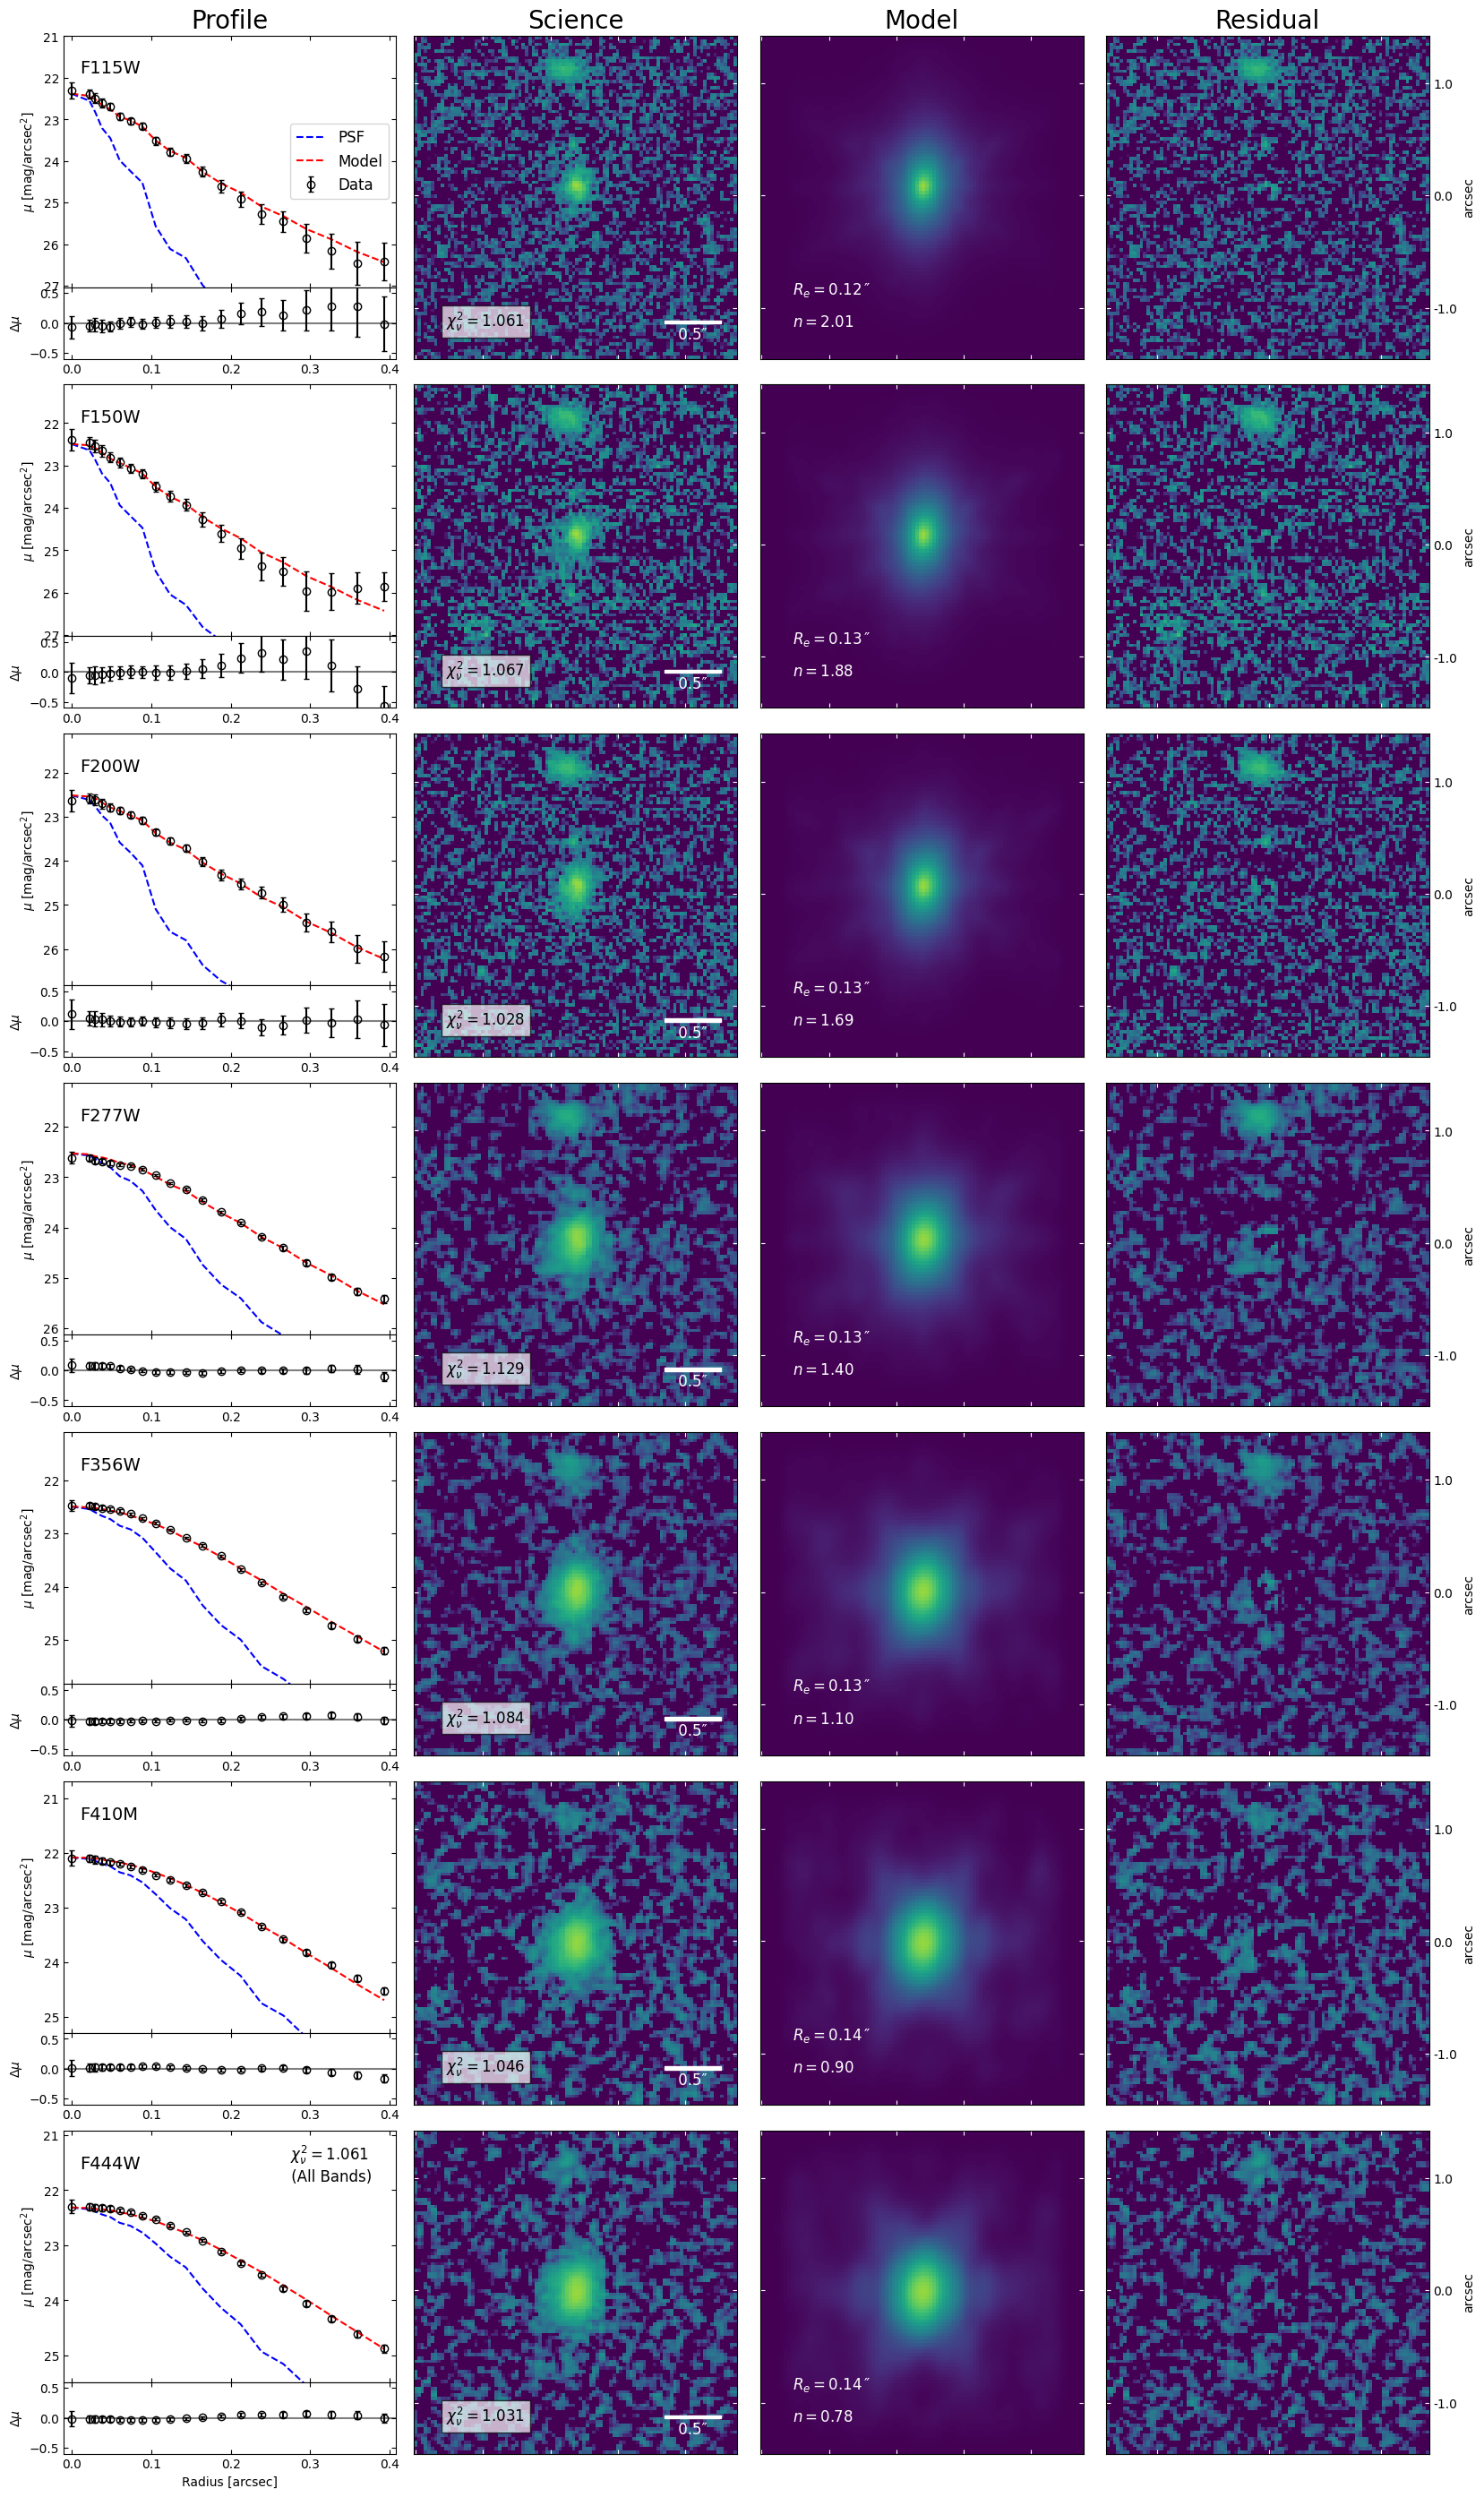

In [11]:
max_radius = 15
n_aper = 20
fig, ax = plt.subplots(7,4,figsize=(17,30), facecolor='w')
with fits.open(sample_dir + output_name + '.fits') as hdul:
    tab_finalband = Table(hdul['FINAL_BAND'].data)
    n_out, rlist = tab_finalband['COMP1_n'], tab_finalband['COMP1_Re']
    ar, pa, re = tab_finalband['COMP1_AR'][0], tab_finalband['COMP1_PA'][0], tab_finalband['COMP1_Re'][3]

        # determine a constant list of radius for each image
    r_out = max(min(3 * np.median(rlist), max_radius), 7.5)
    r_in = 0.01/pix_scale
    S_sqr = stretch.SquaredStretch()
    lin = np.linspace(0,1,n_aper+3)
    radii = np.append(r_in, S_sqr(lin[4:]) * (r_out- r_in) + r_in)
    radii_show = np.append(0, radii[1:])
    #print(radii, radii_show)

    for i in range(7):
        sci = hdul[i+1].data
        model = hdul[i+8].data
        res = hdul[i+15].data
        zpt = hdul[i+8].header[f'MAGZPT_{band_labels[i]}']

        x, y= tab_finalband['COMP1_XC'][i]-1, tab_finalband['COMP1_YC'][i]-1
        re = rlist[i]

            # profile part
        with fits.open(sample_dir + f'raw_{sample_id}.fits') as hdule:
            err = hdule[f'ERR_{band_labels[i]}'].data
        sci_profile, err_profile = sci_to_profile(sci, err, x, y, pa, ar, radii, zpt)
        model_profile = image_to_profile(model, x, y, pa, ar, radii, zpt)
        psf_profile = image_to_profile(psf_imglist[i], 40, 40, pa, ar, radii, zpt)
        psf_scaled = psf_profile * model_profile[0] / psf_profile[0]

        ax[i,0].plot(radii_show*pix_scale, psf_scaled,'b--', label='PSF')
        ax[i,0].plot(radii_show*pix_scale, model_profile,'r--', label='Model')
        ax[i,0].errorbar(radii_show*pix_scale, sci_profile, yerr=err_profile, fmt='o', fillstyle='none', label='Data', capsize=2, color='k')
        ax[i,0].set_ylabel(r'$\mu$ [mag/arcsec$^2$]',)
        ax[i,0].xaxis.set_tick_params(labelbottom=False)
        ymin, ymax = np.min(model_profile), np.max(model_profile)
        ax[i,0].set_ylim(ymax+.6, ymin-1.4)
        ax[i,0].set_xlim(-.01, (r_out+.5)*0.03)

        ax[i,0].text(.05, .85, f'{band_labels[i]}', color='k', fontsize=14, transform = ax[i,0].transAxes)

        divider = make_axes_locatable(ax[i,0])
        ax_offset = divider.append_axes("bottom", 0.8, pad=0, sharex=ax[i,0], transform = ax[i,0].transData)
        ax_offset.errorbar((radii_show)*pix_scale, sci_profile-model_profile, yerr=err_profile, fmt='o', fillstyle='none', capsize=2, color='k')
        ax_offset.set_ylim(-0.6, 0.6)
        ax_offset.plot(ax_offset.get_xlim(),[0,0], 'k-', alpha=0.5, zorder=-10)
        ax_offset.set_ylabel(r'$\Delta\mu$')
        
        # image part
        model_mean, model_std = np.mean(model), np.std(model)
        vmin = max(model_mean - 10*model_std, 0)
        vmax = np.max(model) * 3.
        norm = ImageNormalize(model, stretch=stretch.LogStretch(), vmin=vmin, vmax=vmax)
        ax[i,2].text(.1, .1, f'$n={n_out[i]:.2f}$',color='w', fontsize=12, transform = ax[i,2].transAxes)
        ax[i,2].text(.1, .2, f'$R_e={re*.03:.2f}\,$'+'\u2033', color='w', fontsize=12, transform = ax[i,2].transAxes)
        _ = ax[i,1].imshow(sci, origin='lower', cmap='viridis', norm=norm)
        _ = ax[i,2].imshow(model, origin='lower', cmap='viridis', norm=norm)
        im3 = ax[i,3].imshow(res, origin='lower', cmap='viridis', norm=norm)

        if i==0:    
            size = sci.shape[0]
            arcnum = size*pix_scale//2
            ax[i,3].set_yticks(size//2 + np.arange(-arcnum, arcnum+1,1)/pix_scale)
            ax[i,3].set_xticks(size//2 + np.arange(-arcnum, arcnum+1,1)/pix_scale)
            ax[i,3].set_yticklabels([f'{(tick-size//2)*pix_scale:.1f}' for tick in ax[i,3].get_yticks()])  # Set the tick labels
        else:
            ax[i,3].set_yticks(ax[0,3].get_yticks())
            ax[i,3].set_xticks(ax[0,3].get_xticks())
            ax[i,3].set_yticklabels(ax[0,3].get_yticklabels())

        # chi2  
        chi2 = hdul[8+i].header['CHI2NU']
        t = ax[i,1].text(.1 ,.1 ,r'$\chi^2_\nu=$'+f'{chi2:.3f}',color='k', fontsize=12, ha='left', transform = ax[i,1].transAxes)
        t.set_bbox(dict(facecolor='white', alpha=.7))

        # scalebar
        scalebar = AnchoredSizeBar(ax[i,3].transData,
                            0.5/0.03, ' 0.5\u2033 ', 'lower right', 
                            pad=1,
                            fontproperties={'size': 12},
                            frameon=False,
                            size_vertical=1,
                            color='w'
                            )
        ax[i,1].add_artist(scalebar)

        for j in [1,2,3]:
            ax[i,j].set_xticklabels([])
            if j<3:
                ax[i,j].set_yticks(ax[i,3].get_yticks())
                ax[i,j].set_yticklabels([])
                ax[i,j].tick_params(left=True, labelleft=False, right=True, labelright=False, color='w')
            else:
                ax[i,j].tick_params(left=True, labelleft=False, right=True, labelright=True, color='w')
                ax[i,j].set_ylabel('arcsec')
                ax[i,j].yaxis.set_label_position('right')
        
        
    chi2_tot = Table(hdul['FIT_INFO'].data)['CHI2NU'].data[0]
ax[6,0].text(.8, .8, r'$\chi^2_\nu=$'+f'{chi2_tot:.3f}\n (All Bands)', color='k', fontsize=12, ha='center', transform = ax[6,0].transAxes)
            
ax[0,0].set_title('Profile',  fontsize=20)
ax[0,0].legend(loc='center right', fontsize=12)

ax[0,1].set_title('Science', fontsize=20)
ax[0,2].set_title('Model', fontsize=20)
ax[0,3].set_title('Residual', fontsize=20)
ax_offset.set_xlabel('Radius [arcsec]')
plt.subplots_adjust(wspace=0.04, hspace=0.08, left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig(f'{img_name}_{sample_id}_galfitm.pdf', bbox_inches='tight')

# Second, multicomp fit

18384 27541 13215

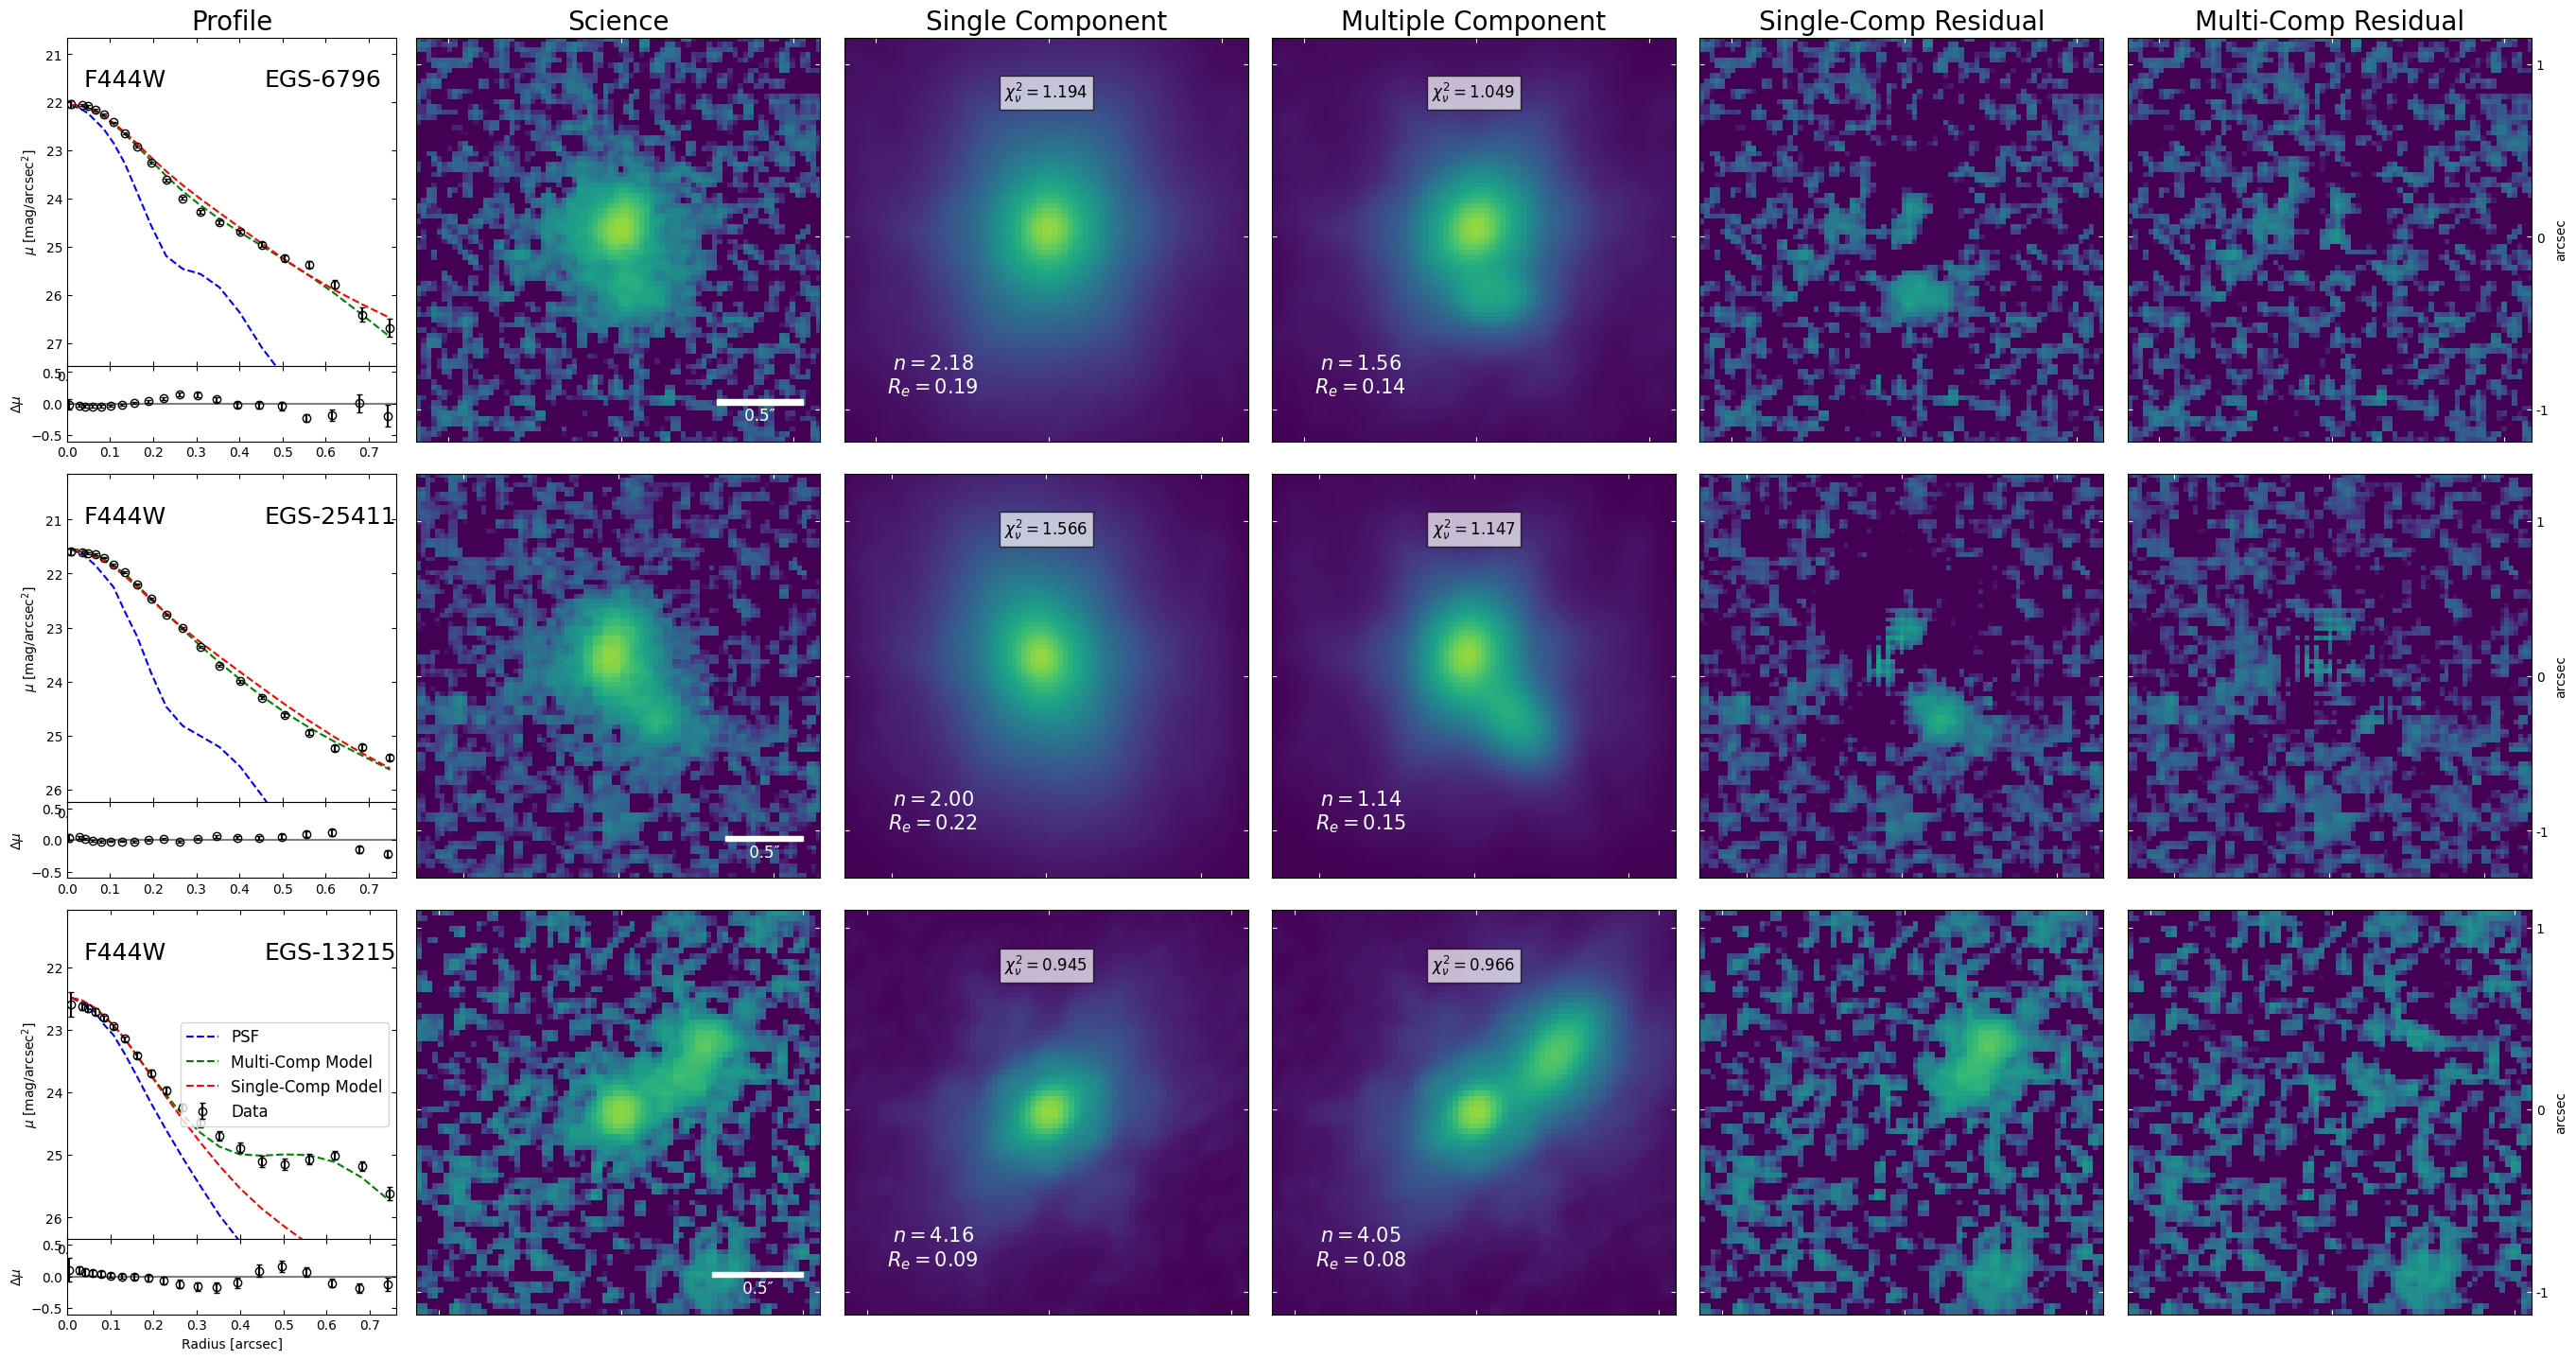

In [21]:
n_aper = 20
fig, ax = plt.subplots(3,6,figsize=(29,15), facecolor='w', gridspec_kw={'width_ratios':[.8,1,1,1,1,1]})
for icol, source_id in enumerate(["6796", "25411", "13215"]):
    fr = [0.6, 0.5, 0.5][icol]
    mcomp_dir = '../multicomp/' + source_id + '/'
    band_seq = 6

    with fits.open(mcomp_dir + 'output_linear.fits') as hdul:
        tab_finalband = Table(hdul['FINAL_BAND'].data)
        n_out, rlist = tab_finalband['COMP1_n'], tab_finalband['COMP1_Re']
        ar, pa, re = tab_finalband['COMP1_AR'][0], tab_finalband['COMP1_PA'][0], tab_finalband['COMP1_Re'][3]

        # determine a constant list of radius for each image
        r_out = max(min(9 * np.median(rlist), 25), 7.5)
        r_in = 0.01/pix_scale
        S_sqr = stretch.SquaredStretch()
        lin = np.linspace(0,1,n_aper+3)
        radii = np.append(r_in, S_sqr(lin[4:]) * (r_out - r_in) + r_in)
        radii_show = np.append(0, radii[1:])

        sci = hdul[band_seq+1].data
        modelm = hdul[band_seq+8].data
        resm = hdul[band_seq+15].data
        zpt = hdul[band_seq+8].header[f'MAGZPT_{band_labels[band_seq]}']
        x, y= tab_finalband['COMP1_XC'][band_seq]-1, tab_finalband['COMP1_YC'][band_seq]-1
        re = rlist[band_seq]
        chi2m = hdul[8+band_seq].header['CHI2NU']
    
        # profile part
    with fits.open(mcomp_dir + f'raw_{source_id}.fits') as hdule:
        err = hdule[f'ERR_{band_labels[band_seq]}'].data

    sci_profile, err_profile = sci_to_profile(sci, err, x, y, pa, ar, radii, zpt)
    modelm_profile = image_to_profile(modelm, x, y, pa, ar, radii, zpt)
    psf_profile = image_to_profile(psf_imglist[band_seq], 40, 40, pa, ar, radii, zpt)
    psf_scaled = psf_profile * modelm_profile[0] / psf_profile[0]

    # compare with single component model
    for point in range(1,11):
        img_name = f'nircam{point}'
        if os.path.exists('../io/sample/' + img_name + '/' + source_id + '/output_linear.fits'):
            sample_dir = '../io/sample/' + img_name + '/' + source_id + '/'

    with fits.open(sample_dir + 'output_linear.fits') as hdul:
        tab_finalband = Table(hdul['FINAL_BAND'].data)
        x, y= tab_finalband['COMP1_XC'][band_seq]-1, tab_finalband['COMP1_YC'][band_seq]-1
        ar, pa = tab_finalband['COMP1_AR'][0], tab_finalband['COMP1_PA'][0]
        ns, rs = tab_finalband['COMP1_n'][band_seq], tab_finalband['COMP1_Re'][band_seq]
        models = hdul[band_seq+8].data
        ress = hdul[band_seq+15].data
        zpt = hdul[band_seq+8].header[f'MAGZPT_{band_labels[band_seq]}']
        models_profile = image_to_profile(models, x, y, pa, ar, radii, zpt)
        chi2s = hdul[8+band_seq].header['CHI2NU']
    
    ax[icol,0].plot(radii*pix_scale, psf_scaled,'b--', label='PSF')
    ax[icol,0].plot(radii*pix_scale, modelm_profile,'g--', label='Multi-Comp Model')
    models_scaled = models_profile * modelm_profile[0] / models_profile[0]
    ax[icol,0].plot(radii*pix_scale, models_scaled, 'r--', label='Single-Comp Model')
    ax[icol,0].errorbar(radii*pix_scale, sci_profile, yerr=err_profile, fmt='o', fillstyle='none', label='Data',
                                capsize=2, color='k')
    ax[icol,0].set_ylabel(r'$\mu$ [mag/arcsec$^2$]')
    ymin, ymax = np.min(modelm_profile), np.max(modelm_profile)
    ax[icol,0].set_ylim(ymax+.6, ymin-1.4)
    ax[icol,0].set_xlim(0, (r_out+.5)*0.03)

    ax[icol,0].text(.05, .85, f'{band_labels[band_seq]}', color='k', fontsize=18, transform = ax[icol,0].transAxes)
    ax[icol,0].text(.6,0.85, f'EGS-{source_id}', color='k', fontsize=18, transform = ax[icol,0].transAxes)

    divider = make_axes_locatable(ax[icol,0])
    ax_offset = divider.append_axes("bottom", 0.8, pad=0, sharex=ax[icol,0], transform = ax[icol,0].transData)
    ax_offset.errorbar((radii-0.2)*pix_scale, sci_profile-modelm_profile, yerr=err_profile, fmt='o', fillstyle='none', capsize=2, color='k')
    ax_offset.set_ylim(-0.6, 0.6)
    ax_offset.plot(ax_offset.get_xlim(),[0,0], 'k-', alpha=0.5, zorder=-10)
    ax_offset.set_ylabel(r'$\Delta\mu$')

    # image part
    model_mean, model_std = np.mean(modelm), np.std(modelm)
    vmin = max(model_mean - 10*model_std, 0)
    vmax = np.max(models) * 3.
    norm = ImageNormalize(models, stretch=stretch.LogStretch(), vmin=vmin, vmax=vmax)

    size = sci.shape[0]
    sci_show = sci[int(size*(1-fr)/2):int(size*(1+fr)/2), int(size*(1-fr)/2):int(size*(1+fr)/2)]
    ax[icol,1].imshow(sci_show, origin='lower', cmap='viridis', norm=norm)
    # scalebar
    scalebar = AnchoredSizeBar(ax[icol,3].transData,
                        0.5/0.03, ' 0.5\u2033 ', 'lower right', 
                        pad=1,
                        fontproperties={'size': 12},
                        frameon=False,
                        size_vertical=1,
                        color='w'
                        )
    ax[icol,1].add_artist(scalebar)

    models_show = models[int(size*(1-fr)/2):int(size*(1+fr)/2), int(size*(1-fr)/2):int(size*(1+fr)/2)]
    ax[icol,2].imshow(models_show, origin='lower', cmap='viridis', norm=norm)
    t2 = ax[icol,2].text(.5 ,.85 ,r'$\chi^2_\nu=$'+f'{chi2s:.3f}',color='k', fontsize=12, ha='center', transform = ax[icol,2].transAxes)
    t2.set_bbox(dict(facecolor='white', alpha=.7))
    t2n = ax[icol,2].text(.22 ,.12 ,f'$n={ns:.2f}$\n$R_e={rs*.03:.2f}\,$',color='w', fontsize=15, transform = ax[icol,2].transAxes, ha='center')

    modelm_show = modelm[int(size*(1-fr)/2):int(size*(1+fr)/2), int(size*(1-fr)/2):int(size*(1+fr)/2)]
    ax[icol,3].imshow(modelm_show, origin='lower', cmap='viridis', norm=norm)
    t3 = ax[icol,3].text(.5 ,.85 ,r'$\chi^2_\nu=$'+f'{chi2m:.3f}',color='k', fontsize=12, ha='center', transform = ax[icol,3].transAxes)
    t3.set_bbox(dict(facecolor='white', alpha=.7))
    t3n = ax[icol,3].text(.22 ,.12 ,f'$n={n_out[band_seq]:.2f}$\n$R_e={rlist[band_seq]*.03:.2f}\,$',color='w', fontsize=15, transform = ax[icol,3].transAxes, ha='center')

    ress_show = ress[int(size*(1-fr)/2):int(size*(1+fr)/2), int(size*(1-fr)/2):int(size*(1+fr)/2)]
    ax[icol,4].imshow(ress_show, origin='lower', cmap='viridis', norm=norm)

    resm_show = resm[int(size*(1-fr)/2):int(size*(1+fr)/2), int(size*(1-fr)/2):int(size*(1+fr)/2)]
    ax[icol,-1].imshow(resm_show, origin='lower', cmap='viridis', norm=norm)

    arcnum = int(size*fr*pix_scale/2)
    if arcnum == 0:
        ax[icol,-1].set_xticks( (size*fr)//2 + np.arange(-.5, 1, 0.5)/pix_scale)  # Set the ticks
        ax[icol,-1].set_xticklabels([f'{(tick-size*fr//2)*pix_scale:.1f}' for tick in ax[icol,-1].get_xticks()])  # Set the tick labels
        ax[icol,-1].set_yticks( (size*fr)//2 + np.arange(-.5, 1, 0.5)/pix_scale)  # Set the ticks
        ax[icol,-1].set_yticklabels([f'{(tick-size*fr//2)*pix_scale:.1f}' for tick in ax[icol,-1].get_yticks()])  # Set the tick labels
    else:
        ax[icol,-1].set_xticks( (size*fr)//2 + np.arange(-arcnum, arcnum+1,1)/pix_scale)  # Set the ticks
        ax[icol,-1].set_xticklabels([f'{(tick-size*fr//2)*pix_scale:.0f}' for tick in ax[icol,-1].get_xticks()])  # Set the tick labels
        ax[icol,-1].set_yticks( (size*fr)//2 + np.arange(-arcnum, arcnum+1,1)/pix_scale)  # Set the ticks
        ax[icol,-1].set_yticklabels([f'{(tick-size*fr//2)*pix_scale:.0f}' for tick in ax[icol,-1].get_yticks()])  # Set the tick labels

    for j in [1,2,3,4,5]:
        ax[icol,j].set_xticklabels([])
        if j!=5:
            ax[icol,j].set_yticks(ax[icol,-1].get_yticks())
            ax[icol,j].set_xticks(ax[icol,-1].get_xticks())
            ax[icol,j].set_yticklabels(ax[icol,-1].get_yticklabels())
            ax[icol,j].tick_params(left=True, labelleft=False, right=True, labelright=False, color='w')
        else:
            ax[icol,j].tick_params(left=True, labelleft=False, right=True, labelright=True, color='w')
            ax[icol,j].set_ylabel('arcsec')
            ax[icol,j].yaxis.set_label_position('right')

ax[0,0].set_title('Profile',  fontsize=20)
ax[2,0].legend(loc='center right', fontsize=12)
ax[0,1].set_title('Science', fontsize=20)
ax[0,2].set_title('Single Component', fontsize=20)
ax[0,3].set_title('Multiple Component', fontsize=20)
ax[0,4].set_title('Single-Comp Residual', fontsize=20)
ax[0,5].set_title('Multi-Comp Residual', fontsize=20)
ax_offset.set_xlabel('Radius [arcsec]')
plt.subplots_adjust(wspace=0.04, hspace=0.08, left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig(f'multicomp_comparison.pdf', bbox_inches='tight')
plt.show()

# Third, show image atlas

In [56]:
from astropy.visualization import make_lupton_rgb

../io/sample/nircam1/


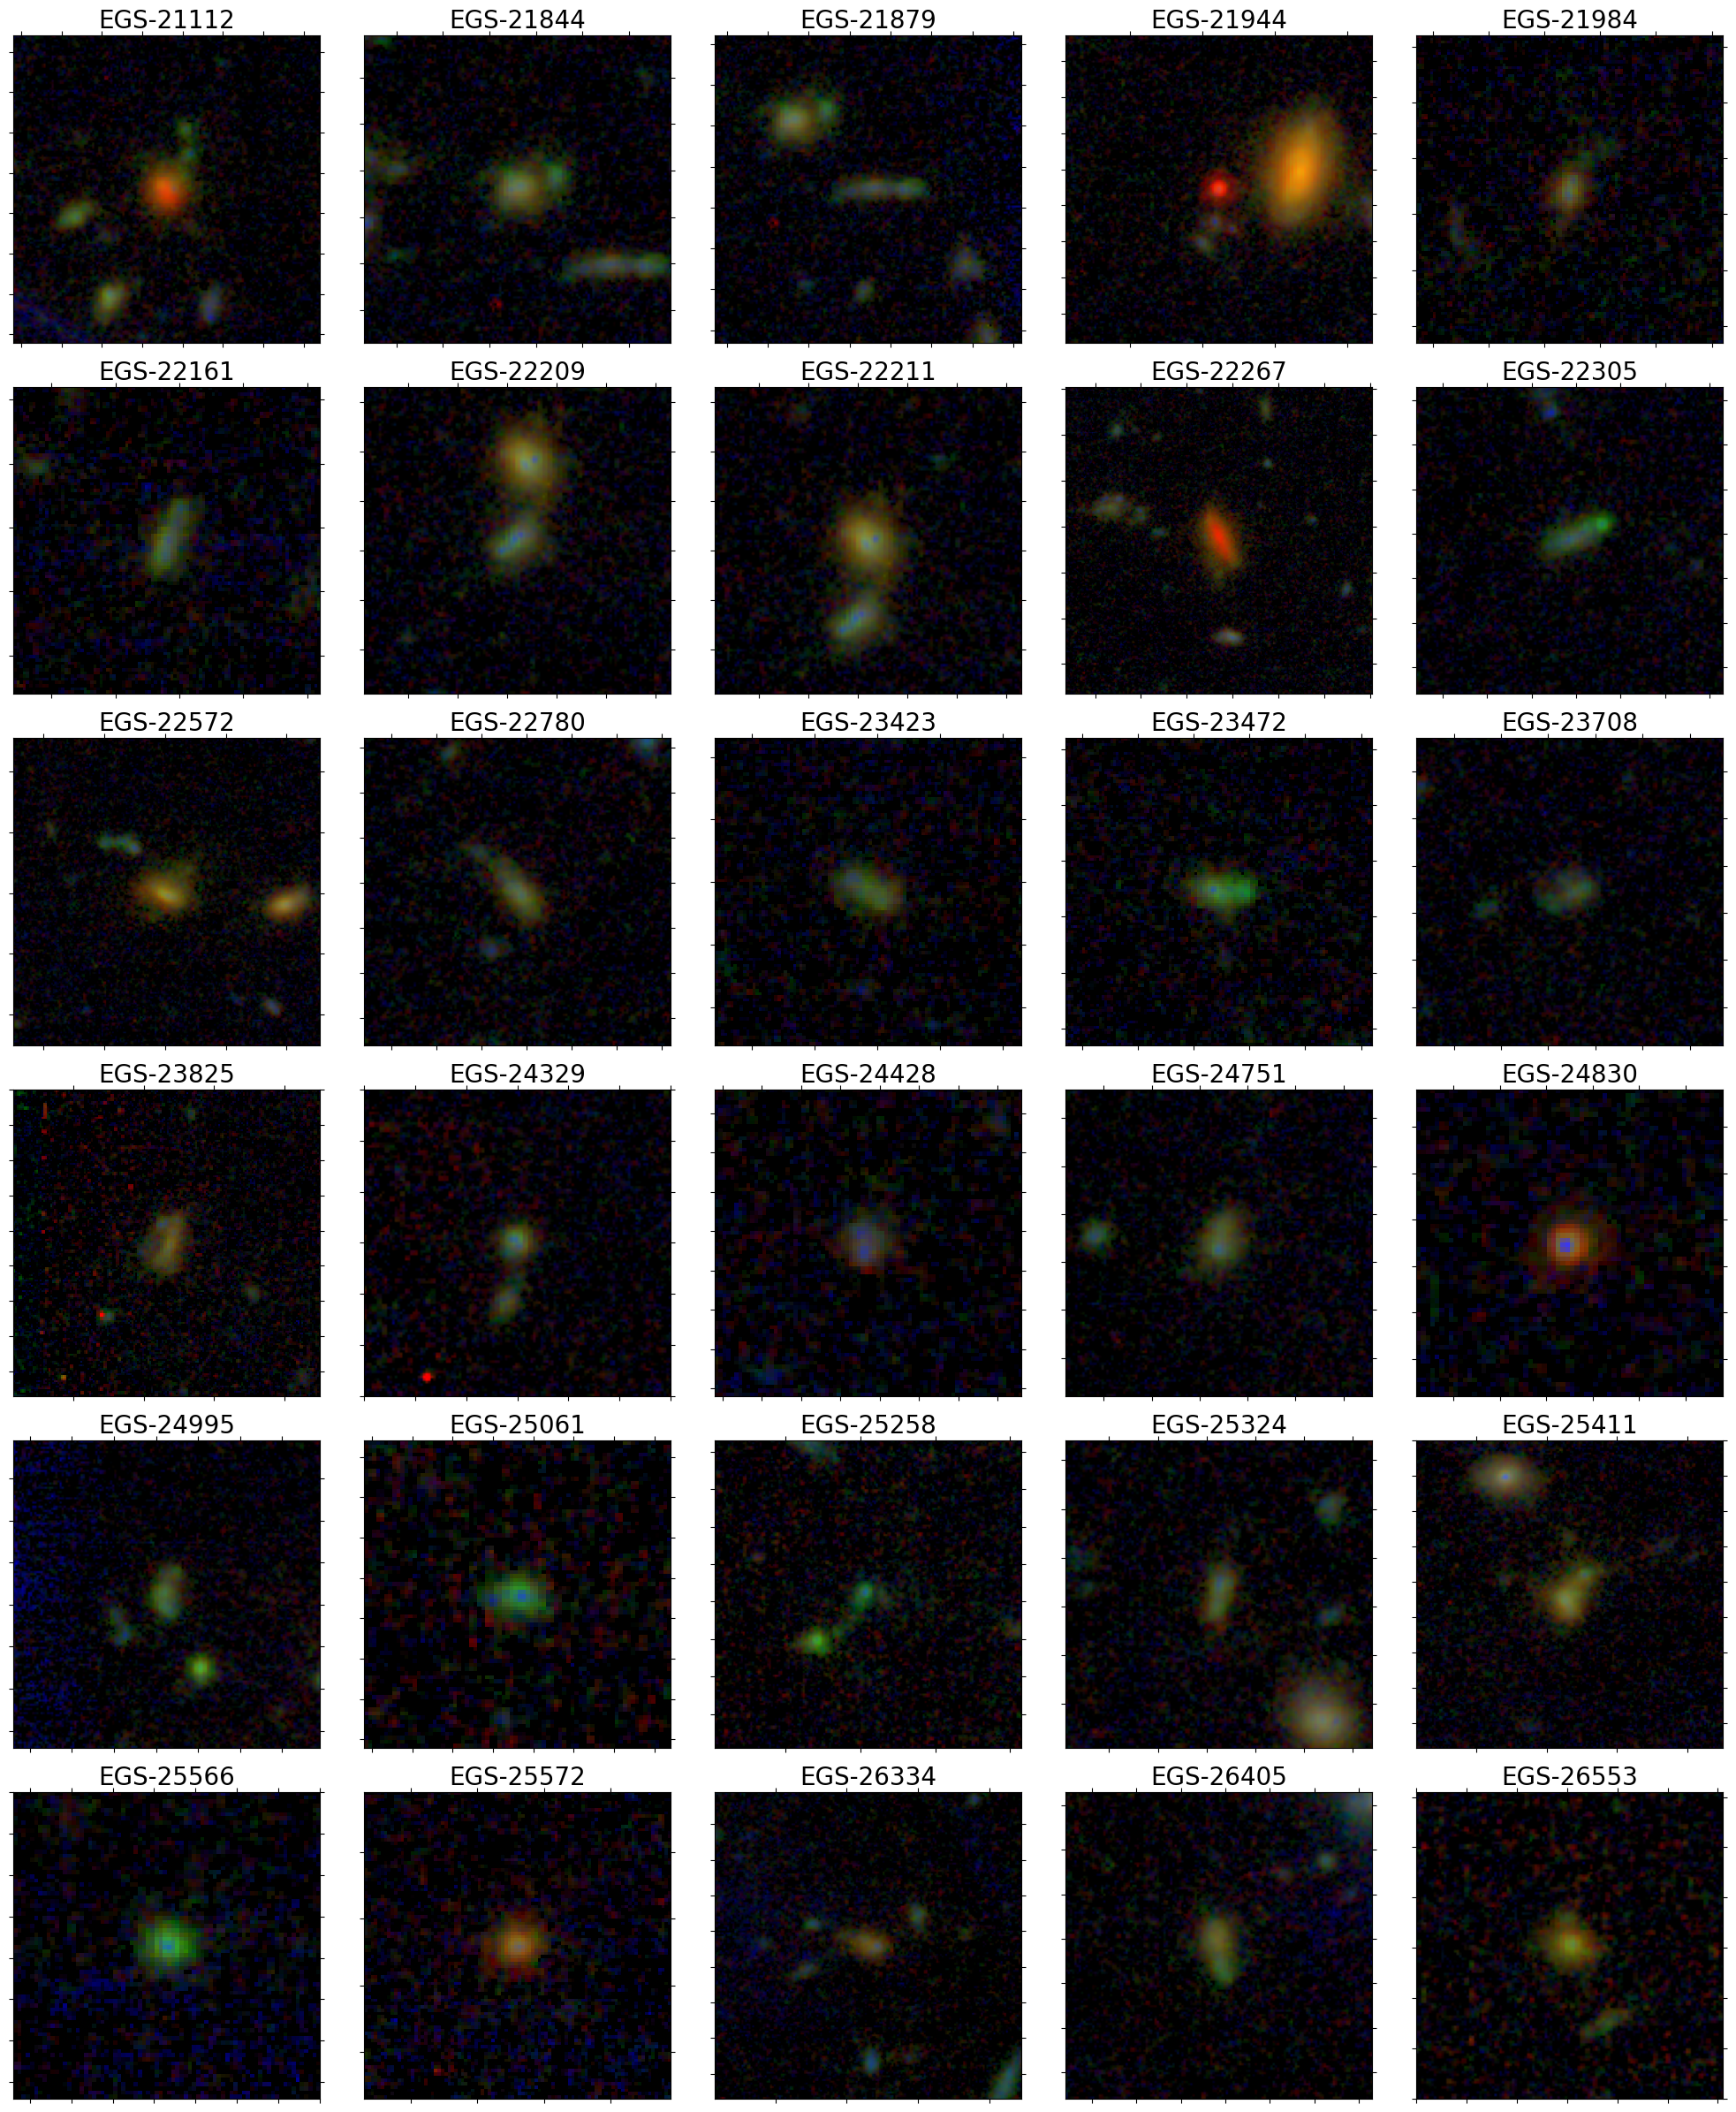

ValueError: Too many images

In [73]:
xaxis = 5
yaxis = 6
fig, ax = plt.subplots(yaxis, xaxis, figsize=(20, 24))
fig.patch.set_color('w')
i = 0
j = 0
img_base_list = ['../io/sample/nircam'+str(i)+'/' for i in range(1,11)]
for img_base_dir in img_base_list:
    print(img_base_dir)
    img_dir_list = glob.glob(img_base_dir + '*/')
    img_dir_list.sort()
    for img_dir in img_dir_list:
        img_b = fits.getdata(img_dir + 'sci_F115W.fits')
        img_g = fits.getdata(img_dir + 'sci_F277W.fits')
        img_r = fits.getdata(img_dir + 'sci_F444W.fits')
        img = make_lupton_rgb(img_r, img_g, img_b, stretch=.07, Q=15)
        ax[i,j].imshow(img, cmap='gray', extent=[int(img.shape[1]*.25), int(img.shape[1]*.75), int(img.shape[0]*.25), int(img.shape[0]*.75)])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_title('EGS-'+img_dir.split('/')[-2], fontsize=20,)
        
        j += 1
        if j == xaxis:
            j = 0
            i += 1
            if i == yaxis:
                plt.tight_layout()
                plt.savefig('egs_example.pdf')
                plt.show()
                raise ValueError('Too many images')
